In [1]:
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

from multilevel_cutpoint_model import CutpointModel
# from multilevel_cutpoint_model import discrete_ci
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from node import Node

# Make Moons

In [2]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [3]:
# y_moon indicates if the data will be in the first bucket or the second
N = 10000
X, y_moon = make_moons(n_samples = N, noise=0.3, random_state=1978)

# drop 1/2 of the 1 moons 
# want y_moon plot to look even and censoring to look even
# try higher value of sigmoid if it can't find the cutpoint
combined = np.append(X, y_moon[:,None], 1)
combined_sorted = combined[combined[:, -1].argsort()]
combined_sorted = combined_sorted[:7500,:]
np.random.shuffle(combined_sorted)
X = combined_sorted[:,:-1]
y_moon = combined_sorted[:,-1]

t_min = 0
t_boundary = 67
t_max = 100
t = np.zeros(len(y_moon))

# s = np.random.binomial(1, 0.5, len(y_moon))
s = np.random.binomial(1, 1, len(y_moon))

for ii in range(0, len(y_moon)):
    if y_moon[ii] == 0:
        t[ii] = np.random.uniform(t_min, t_boundary)
    elif y_moon[ii] == 1:
        
        t[ii] = np.random.uniform(t_boundary, t_max)
        
# t = t[1:int(N * 3/4)]
# s = s[1:int(N * 3/4)]
# y_moon = y_moon[1:int(N * 3/4)]
# X = X[1:int(N * 3/4), :]

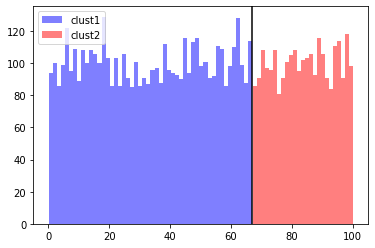

In [4]:
plt.hist(t[y_moon==0], bins=50, alpha = 0.5, color = "blue", label="clust1")
plt.hist(t[y_moon==1], bins=25, alpha = 0.5, color = "red", label="clust2")
plt.axvline(t_boundary, color="black")
plt.legend()
plt.show()

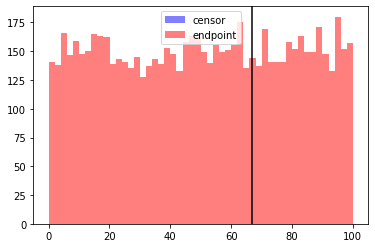

In [5]:
plt.hist(t[s==0], bins=50, alpha = 0.5, color = "blue", label="censor")
plt.hist(t[s==1], bins=50, alpha = 0.5, color = "red", label="endpoint")
plt.axvline(67, color="black")
plt.legend()
plt.show()

In [6]:
X_train, X_test, \
t_train, t_test,\
s_train, s_test = train_test_split(
    X, t, s, test_size=0.2, random_state=1978
)

In [7]:
print((t_train[0:5] - min(t_train)) / (max(t_train) - min(t_train)) )

[0.63294926 0.88685329 0.42019239 0.26377374 0.08821319]


In [8]:
from multilevel_cutpoint_model import CutpointModel

m = CutpointModel(X_train, t_train, s_train, sigmoid_temperature = 0.01, depth = 0, iterations = 250, prior_strength = 0.0)
m.train()

1
loss 1.3540555238723755
cutpoint 0.25
2
loss 1.3333358764648438
cutpoint 0.23999999463558197
3
loss 1.3127108812332153
cutpoint 0.23000775277614594
4
loss 1.2919172048568726
cutpoint 0.2200259566307068
5
loss 1.270562767982483
cutpoint 0.2100333273410797
6
loss 1.2483376264572144
cutpoint 0.19999638199806213
7
loss 1.2254172563552856
cutpoint 0.18990060687065125
8
loss 1.2022637128829956
cutpoint 0.1797490417957306
9
loss 1.1791930198669434
cutpoint 0.16956253349781036
10
loss 1.1561285257339478
cutpoint 0.15936820209026337
11
loss 1.1327012777328491
cutpoint 0.1491706520318985
12
loss 1.1085485219955444
cutpoint 0.13894453644752502
13
loss 1.0836137533187866
cutpoint 0.12865813076496124
14
loss 1.0581213235855103
cutpoint 0.11829770356416702
15
loss 1.0321578979492188
cutpoint 0.10786556452512741
16
loss 1.0055201053619385
cutpoint 0.0973576009273529
17
loss 0.9781254529953003
cutpoint 0.0867600291967392
18
loss 0.9500983357429504
cutpoint 0.07606635242700577
19
loss 0.9216409921646

ValueError: Expected value argument (Tensor of shape ()) to be within the support (Interval(lower_bound=0.0, upper_bound=1.0)) of the distribution Beta(), but found invalid values:
-0.009712642058730125

In [ ]:
m.plot_result(t_train[s_train==1], t_train[s_train==0])

In [ ]:
def discrete_ci(cutpoints, model, X_test_in, t_test_in, s_test_in, t_train_in):
    s_test = torch.from_numpy(s_test_in).float()
    X_test = torch.from_numpy(X_test_in).float()
    t_test = torch.from_numpy(t_test_in).float()
    t_train = torch.from_numpy(t_train_in).float()

    # predicted bucket probabilities for test data

    # move pred to it's own class function, call it outside of this and just pass in the predictions
    pred = model(X_test).detach().numpy()    
    
    # cdfs
    t_pred_cdf = np.cumsum(pred, axis=1) 

    bucket_boundaries = [0] + sorted([i.item() for i in cutpoints]) + [1]
    # rescale
    bucket_boundaries = [boundary_i * (max(t_train) - min(t_train)) + min(t_train) 
                             for boundary_i in bucket_boundaries]
    
    N = len(pred)
    n_buckets = len(bucket_boundaries) - 1

    # one hot vector for where the 1 is in the most likely bucket
    t_true_idx = np.zeros((N, n_buckets),dtype=int)
    for ii in range(N):
        for jj in range(n_buckets):
            if t_test[ii] < bucket_boundaries[jj+1]:
                t_true_idx[ii][jj] = 1
                break
           
    print(bucket_boundaries[0:10])
    print(t_test[0:10])
    print(t_true_idx[0:10])
    
    t_true_idx = np.argmax(t_true_idx, axis=1)
    concordant = 0
    total = 0


    idx = np.arange(N)

    
    
    for i in range(N):

        if s_test[i] == 0:
            continue

        # time bucket of observation for i, then for all but i
        tti_idx = t_true_idx[i]
        
        tt_idx = t_true_idx[idx != i]

        # calculate predicted risk for i at the time of their event
        tpi = t_pred_cdf[i, tti_idx]


        # predicted risk at that time for all but i
        tp = t_pred_cdf[idx != tti_idx, tti_idx]

        
        total += np.sum(tti_idx < tt_idx) # observed in i first

        concordant += np.sum((tti_idx < tt_idx) * (tpi > tp)) # and i predicted as higher risk

    return concordant / total


In [ ]:
discrete_ci(m.cutpoints, m.layers[-1], X_test, t_test, s_test, t_train)

In [ ]:
discrete_ci(m.cutpoint0, m.layers[-1], X_test, t_test, s_test, t_train)

In [ ]:
discrete_ci(torch.tensor([0.5]), m.layers[-1], X_test, t_test, s_test, t_train)

## Tri-modal

In [ ]:
# shifted and scaled sigmoid function
def test_sigmoid(x, a=0, b=1.):
    return 1 / (1 + (np.exp(-1 * (x - a) / b)))

N = 10000
P = 5

rs = np.random.RandomState(1978)

X = rs.randn(N, P)
w = rs.randn(P)

y_prob = test_sigmoid(X @ w)
y = (rs.rand(N) < y_prob).astype(int)
t = (rs.randn(N) + 5 * y + (rs.rand(N)> 0.5) * 5 * y )

# make times positive
t += abs(min(t))

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="False")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="True")
plt.legend()
plt.show()

In [ ]:
m = CutpointModel(X, t, y, X, t, y, depth = 1, iterations = 500)

In [ ]:
for name, param in m.named_parameters():
    if param.requires_grad:
        print(name, param.data)

In [ ]:
m.train()

In [ ]:
m.cutpoint0

In [ ]:
for name, param in m.named_parameters():
    if param.requires_grad:
        print(name, param.data)

In [ ]:
m.plot_result(t[y==1], t[y==0])

In [ ]:
discrete_ci(m.cutpoints, m.layers[-1], X, t, y, t)

In [ ]:
discrete_ci(m.cutpoint0, m.layers[-1], X, t, y, t)

In [ ]:
discrete_ci(torch.tensor([0.9, 0.99, 0.999]), m.layers[-1], X, t, y, t)

## more modes

In [ ]:
N = 1000
P = 5

rs = np.random.RandomState(1978)
# python please I want a do while loop

X = rs.randn(N, P)
w = rs.randn(P)

y_prob = test_sigmoid(X @ w)
y = (rs.rand(N) < y_prob).astype(int)
t = (rs.randn(N) + 5 * y )


for i in range(0, 3):
    X_i = rs.randn(N, P)
    w_i = rs.randn(P)

    y_prob = test_sigmoid(X_i @ w_i)
    y_i = (rs.rand(N) < y_prob).astype(int)
    t_i = (rs.randn(N) + 20 * i + 5 * y_i )
    X = np.concatenate((X, X_i))
    t = np.concatenate((t, t_i))
    y = np.concatenate((y, y_i))
    

# make times positive
t += abs(min(t))

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="False")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="True")
plt.legend()
plt.show()

In [ ]:
m = Model(X, t, depth = 2, iterations = 1000)
m.train()
m.plot_result(t[y==1], t[y==0])

# Sksurv data

## Breast Cancer

In [ ]:
from sksurv.datasets import load_breast_cancer

data_x, data_y = load_breast_cancer()
y_df = pd.DataFrame.from_records(data_y)

# cut last covariates that are strings
X = torch.tensor(data_x.iloc[:, 1:-3].values)

t = torch.from_numpy(y_df["t.tdm"].values)


plt.hist(y_df[~y_df["e.tdm"]]["t.tdm"], bins = 20, alpha=0.5, color="blue", label="no metastases")
plt.hist(y_df[y_df["e.tdm"]]["t.tdm"], bins = 20, alpha=0.5, color="red", label="metastases")
plt.legend()

plt.show()

In [ ]:
m = Model(X, t, depth = 1, iterations=1000)
m.train()
m.plot_result(y_df[y_df["e.tdm"]]["t.tdm"], 
              y_df[~y_df["e.tdm"]]["t.tdm"],
             title="Breast Cancer Survival Distribution",
             label_true="metastases",
             label_false="no metastases")

### Worcester Heart Attack Study

The dataset has 500 samples and 14 features. The endpoint is death, which occurred for 215 patients (43.0%).

In [ ]:
from sksurv.datasets import load_whas500

data_x, data_y = load_whas500()
y_df = pd.DataFrame.from_records(data_y)


X = torch.tensor(data_x[["age", "bmi", "diasbp", "hr", "los", "sysbp"]].values)

t = torch.from_numpy(y_df["lenfol"].values)
plt.title("Worcester Heart Attack Study Followup Distribution")
plt.hist(t[~y_df["fstat"].values], color="blue", alpha = 0.5, label="Survived")
plt.hist(t[y_df["fstat"].values], color="red", alpha = 0.5, label = "Died")
plt.legend()
plt.show()

In [ ]:
m = Model(X, t, depth = 2, iterations=1000)
m.train()
m.plot_result(t[y_df["fstat"].values], 
             t[~y_df["fstat"].values],
             title="Worcester Heart Attack Study Followup Distribution",
             label_true="Died",
             label_false="Survived")

# NACD Data

In [ ]:
df= pd.read_csv('http://pssp.srv.ualberta.ca/system/predictors/datasets/000/000/032/original/All_Data_updated_may2011_CLEANED.csv?1350302245')
t = df["SURVIVAL"]
# make times positive
t += abs(min(t))

# censored: 1 is that they were censored 0 they experienced the event
y = 1 - df["CENSORED"]

numrc_cols = df.nunique() > 2
df.loc[:, numrc_cols] = (df.loc[:, numrc_cols] - df.loc[:, numrc_cols].mean()) / df.loc[:, numrc_cols].std()

OUTCOMES = ['SURVIVAL', 'CENSORED']
X = df.drop(OUTCOMES, axis=1).sample(frac=1, random_state=2021)
X = X.values

print('There are', X.shape[1], 'features')
print(f"There are {X.shape[0]} patients")

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="censored")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="endpoint")
plt.legend()
plt.show()

In [ ]:
m = Model(X, t, depth = 2, iterations = 1000)
m.train()
m.plot_result(t[y==1],
              t[y==0],
              title="NACD Survival Distribution",
              label_true = "endpoint",
              label_false = "censored"
             )

# Support dataset

In [ ]:
FILL_VALUES = {
    'alb': 3.5,
    'pafi': 333.3,
    'bili': 1.01,
    'crea': 1.01,
    'bun': 6.51,
    'wblc': 9.,
    'urine': 2502.
}

TO_DROP = ['aps', 'sps', 'surv2m', 'surv6m', 'prg2m', 'prg6m', 'dnr', 'dnrday']
TO_DROP = TO_DROP + ['sfdm2', 'hospdead']

# load, drop columns, fill using specified fill values
df = pd.read_csv('datasets/support2.csv').drop(TO_DROP,axis=1).fillna(value=FILL_VALUES)

# get dummies for categorical vars
df = pd.get_dummies(df, dummy_na=True)

# fill remaining values to the median

df = df.fillna(df.median())

# standardize numeric columns

numrc_cols = df.dtypes == 'float64'
df.loc[:, numrc_cols] = (df.loc[:, numrc_cols] - df.loc[:, numrc_cols].mean()) / df.loc[:, numrc_cols].std()

OUTCOMES = ['death', 'd.time']
X = df.drop(OUTCOMES, axis=1).sample(frac=1, random_state=2021)
X = X.values

t = df["d.time"]
y = df['death']

print('There are', X.shape[1], 'features')
print(f'There are {X.shape[0]} patients')

plt.hist(t[y==0], bins=50, alpha = 0.5, color = "blue", label="censored")
plt.hist(t[y==1], bins=50, alpha = 0.5, color = "red", label="death")
plt.legend()
plt.show()

In [ ]:
m = Model(X, t.values, depth = 2, iterations=1000)
m.train()
m.plot_result(t[y==1],
              t[y==0],
              title="Support Survival Distribution",
              label_true = "endpoint",
              label_false = "censored"
             )

In [ ]:
len(m.theta)

In [ ]:
len(m.theta[0])

In [ ]:
len(m.theta[1])

In [ ]:
len(m.theta[2])